In [1]:

import torch
from torch import nn
from torch import optim
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

from torchsummary import summary
import imageVisualizationHelper 
from custom_resnet import ResNet
import commonHelper
import trainLoopHelper
import testLoopHelper
import datasetProvider

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
DATA_FOLDER = "../../data"
from torch.utils.data import Dataset
image_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = commonHelper.get_device(use_seed=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 89972393.98it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---->TRAINING data with transform


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

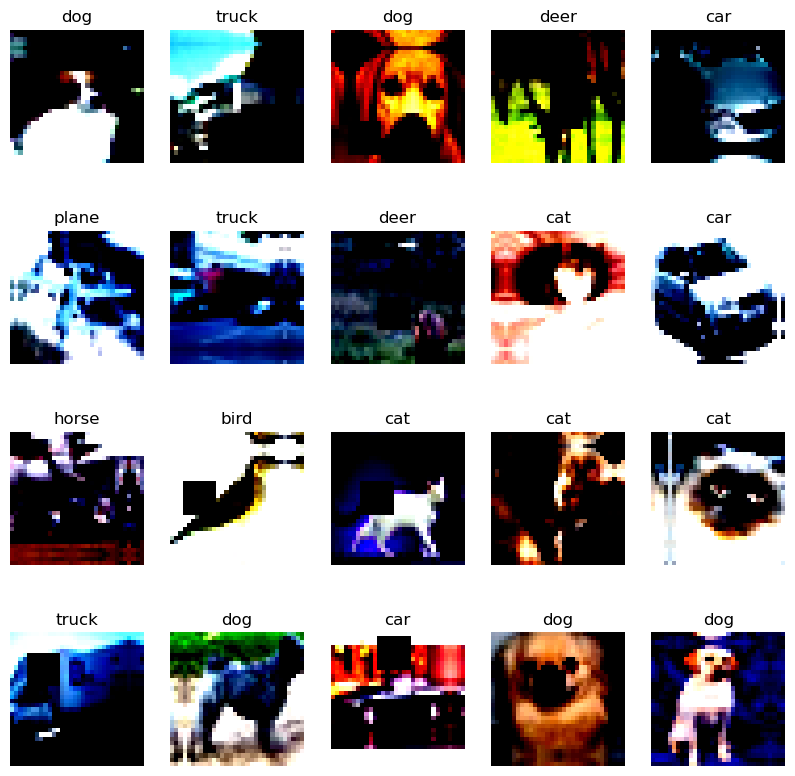

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


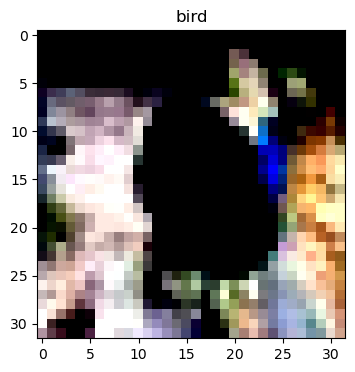

In [3]:

# Download training data from open datasets.
train_transforms_collection = []
train_transforms_collection.extend(datasetProvider.create_random_resize_crop_transformation())
train_transforms_collection.append(datasetProvider.create_flip_transformation(is_horizontal=True))
train_transforms_collection.append(datasetProvider.create_coarse_drop_out_transformation(max_height=8, max_width=8, fill_value=[0.4914, 0.4822, 0.4465]))
train_transforms_collection.extend(datasetProvider.create_basic_transforms_collection())

train_transforms = datasetProvider.compose_custom_transforms(train_transforms_collection)
test_transforms = datasetProvider.compose_custom_transforms(datasetProvider.create_basic_transforms_collection())

train_dataset, test_dataset = datasetProvider.get_CIFAR10_datasets(train_transforms_collection=train_transforms,
                                                                   test_transforms_collection=test_transforms,
                                                                    data_folder=DATA_FOLDER)

print("---->TRAINING data with transform")
imageVisualizationHelper.randomly_show_images_from_tensor_array(train_dataset, image_classes, rows=4, cols=5)


# print("---->TEST data with transform")
# imageVisualizationHelper.randomly_show_images_from_tensor_array(test_dataset, image_classes, rows=4, cols=4)

# Show single image
sample_idx = torch.randint(0, len(test_dataset), size=(1,))  
image_data, label = test_dataset[sample_idx.item()]
imageVisualizationHelper.show_image(image_data, image_classes[label])


In [14]:

BATCH_SIZE = 512
train_dataloader, test_dataloader = datasetProvider.get_dataloaders(train_dataset=train_dataset,
                                                                    test_dataset=test_dataset,
                                                                    batch_size=BATCH_SIZE)
                                                                    


Shape of test_dataloader batch_data [Batch, C, H, W]: torch.Size([512, 3, 32, 32])
Shape of test_dataloader label (label): torch.Size([512]) torch.int64


In [21]:
def get_model_instance(index=1, input_size=(3,32,32)) -> nn.Module:
    if(index <= 1 ):
        model = ResNet().to(device=device)
        summary(model=model, input_size=input_size)
        return model


model = get_model_instance(index=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 32, 32]          73,728
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
          Dropout-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         147,456
      BatchNorm2d-14          [-1, 128,

In [22]:
def get_correct_prediction_count(predictions : torch.Tensor, valid_labels):
  # torch.argmax locates the indices of the maximum elements within a tensor.
  # It does this along a specified dimension (axis).
  return predictions.argmax(dim=1).eq(valid_labels).sum().item()

In [23]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []

train_accuracy = []
test_accuracy = []

MAX_IMAGES_FOR_DISPLAY = 20

correctly_predicted_trained_images = []
wrongly_predicted_trained_images = []

correctly_predicted_test_images = []
wrongly_predicted_test_images = []

In [24]:

def train_loop(dataloader, model, loss_fn, optimizer : optim.Optimizer):
    batch_train_accuracy, batch_train_losses, correctly_predicted_images, wrongly_predicted_images = trainLoopHelper.train_loop(dataloader, model, loss_fn, optimizer)
    train_accuracy.append(batch_train_accuracy)
    train_losses.append(batch_train_losses)

    if(len(correctly_predicted_trained_images) < MAX_IMAGES_FOR_DISPLAY):
        correctly_predicted_trained_images.extend(correctly_predicted_images)

    if(len(wrongly_predicted_trained_images) < MAX_IMAGES_FOR_DISPLAY):
        wrongly_predicted_trained_images.extend(wrongly_predicted_images)


In [25]:


def test_loop(dataloader, model, loss_fn):

        batch_test_accuracy, batch_test_losses, correctly_predicted_images, wrongly_predicted_images = testLoopHelper.test_loop(dataloader, model, loss_fn)
        test_accuracy.append(batch_test_accuracy)
        test_losses.append(batch_test_losses)

        if(len(correctly_predicted_test_images) < MAX_IMAGES_FOR_DISPLAY):
            correctly_predicted_test_images.extend(correctly_predicted_images)

        if(len(wrongly_predicted_test_images) < MAX_IMAGES_FOR_DISPLAY):
            wrongly_predicted_test_images.extend(wrongly_predicted_images)


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.56E-01


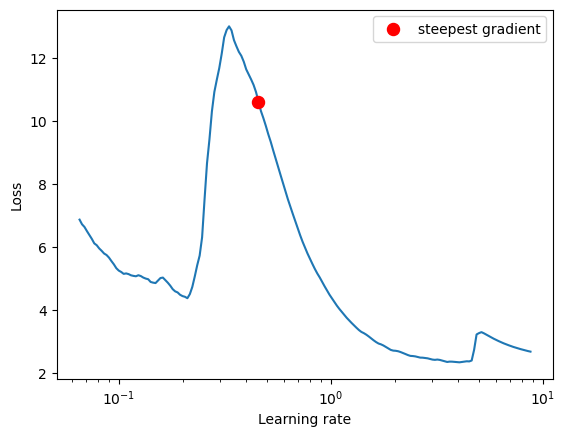

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=10, num_iter=200, step_mode="exp")

lr_finder.plot()
lr_finder.reset()

In [27]:
# LEARNING_RATE = 0.01
EPOCHS = 24
# MOMENTUM = 0.85

correctly_predicted_trained_images = []
wrongly_predicted_trained_images = []
correctly_predicted_test_images = []
wrongly_predicted_test_images = []

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr= 4.56E-01,
                                                pct_start = 5/EPOCHS,
                                                div_factor=100,
                                                final_div_factor=1000,
                                                anneal_strategy = "linear",
                                                steps_per_epoch=len(train_dataloader),
                                                epochs=EPOCHS)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8, verbose=True)


for t in range(EPOCHS):
    print(f"Epoch {t+1}")
    train_loop(train_dataloader, model, criterion, optimizer)
    test_loop(test_dataloader, model, criterion)
    scheduler.step()

print("Done!")

Epoch 1


Train: Loss=1.3278 Batch_id=97 Accuracy=37.32: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 26.2207, Accuracy: 5132/10000 (51.32%)

Epoch 2


Train: Loss=1.1139 Batch_id=97 Accuracy=57.36: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]


Test set: Average loss: 20.5869, Accuracy: 6401/10000 (64.01%)

Epoch 3


Train: Loss=0.9758 Batch_id=97 Accuracy=65.80: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 19.3066, Accuracy: 6762/10000 (67.62%)

Epoch 4


Train: Loss=0.8209 Batch_id=97 Accuracy=69.13: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 16.5738, Accuracy: 7266/10000 (72.66%)

Epoch 5


Train: Loss=0.7103 Batch_id=97 Accuracy=74.07: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]


Test set: Average loss: 16.6501, Accuracy: 7328/10000 (73.28%)

Epoch 6


Train: Loss=0.6139 Batch_id=97 Accuracy=76.21: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 12.1374, Accuracy: 8026/10000 (80.26%)

Epoch 7


Train: Loss=0.5560 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 14.2196, Accuracy: 7712/10000 (77.12%)

Epoch 8


Train: Loss=0.3649 Batch_id=97 Accuracy=79.87: 100%|██████████| 98/98 [00:13<00:00,  7.42it/s]


Test set: Average loss: 11.2254, Accuracy: 8137/10000 (81.37%)

Epoch 9


Train: Loss=0.5446 Batch_id=97 Accuracy=81.92: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 10.3308, Accuracy: 8272/10000 (82.72%)

Epoch 10


Train: Loss=0.3431 Batch_id=97 Accuracy=83.70: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]


Test set: Average loss: 10.7588, Accuracy: 8308/10000 (83.08%)

Epoch 11


Train: Loss=0.4925 Batch_id=97 Accuracy=84.48: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 12.4431, Accuracy: 8060/10000 (80.60%)

Epoch 12


Train: Loss=0.4131 Batch_id=97 Accuracy=84.94: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 9.1680, Accuracy: 8471/10000 (84.71%)

Epoch 13


Train: Loss=0.4847 Batch_id=97 Accuracy=84.93: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 12.6417, Accuracy: 8125/10000 (81.25%)

Epoch 14


Train: Loss=0.3470 Batch_id=97 Accuracy=84.86: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 9.8711, Accuracy: 8386/10000 (83.86%)

Epoch 15


Train: Loss=0.3470 Batch_id=97 Accuracy=87.30: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 8.8397, Accuracy: 8553/10000 (85.53%)

Epoch 16


Train: Loss=0.3041 Batch_id=97 Accuracy=87.82: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 8.0266, Accuracy: 8662/10000 (86.62%)

Epoch 17


Train: Loss=0.3195 Batch_id=97 Accuracy=88.17: 100%|██████████| 98/98 [00:13<00:00,  7.42it/s]


Test set: Average loss: 10.1447, Accuracy: 8404/10000 (84.04%)

Epoch 18


Train: Loss=0.3864 Batch_id=97 Accuracy=88.28: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 8.8284, Accuracy: 8618/10000 (86.18%)

Epoch 19


Train: Loss=0.2811 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 10.0270, Accuracy: 8520/10000 (85.20%)

Epoch 20


Train: Loss=0.2577 Batch_id=97 Accuracy=89.64: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]


Test set: Average loss: 9.5030, Accuracy: 8602/10000 (86.02%)

Epoch 21


Train: Loss=0.4189 Batch_id=97 Accuracy=90.73: 100%|██████████| 98/98 [00:13<00:00,  7.40it/s]


Test set: Average loss: 9.9705, Accuracy: 8546/10000 (85.46%)

Epoch 22


Train: Loss=0.2707 Batch_id=97 Accuracy=89.18: 100%|██████████| 98/98 [00:13<00:00,  7.38it/s]


Test set: Average loss: 9.0736, Accuracy: 8686/10000 (86.86%)

Epoch 23


Train: Loss=0.2151 Batch_id=97 Accuracy=90.79: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]


Test set: Average loss: 8.3394, Accuracy: 8750/10000 (87.50%)

Epoch 24


Train: Loss=0.3097 Batch_id=97 Accuracy=91.66: 100%|██████████| 98/98 [00:13<00:00,  7.39it/s]


Test set: Average loss: 10.2282, Accuracy: 8589/10000 (85.89%)

Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

----****----Wrongly predicted test images: 20


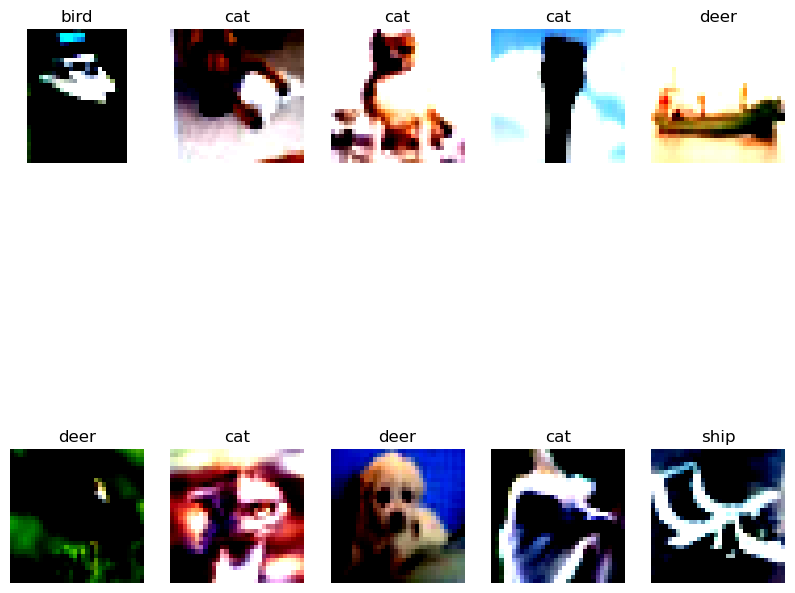

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

----****----Correctly predicted test images: 20


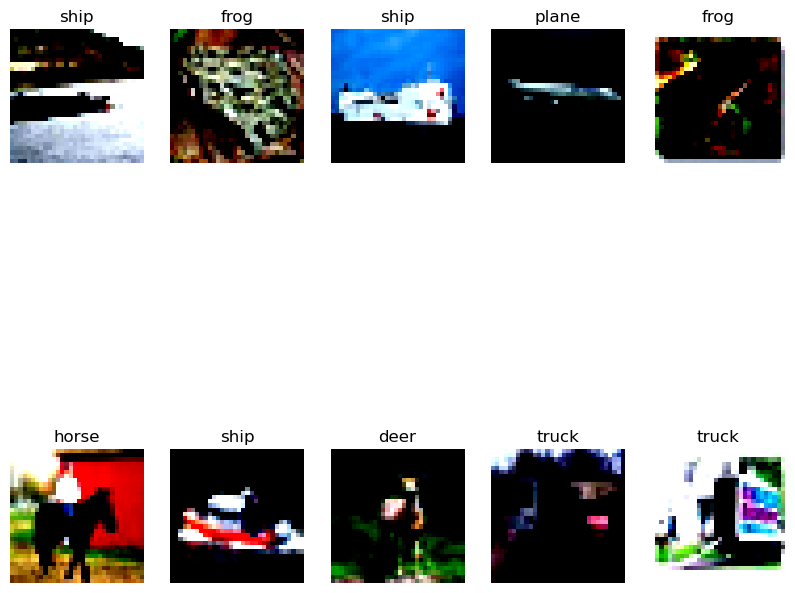

In [28]:

print(f"----****----Wrongly predicted test images: {len(wrongly_predicted_test_images)}")
imageVisualizationHelper.show_images_from_tensor_array(wrongly_predicted_test_images, image_classes, rows=2, cols=5)

print(f"----****----Correctly predicted test images: {len(correctly_predicted_test_images)}")
imageVisualizationHelper.show_images_from_tensor_array(correctly_predicted_test_images, image_classes, rows=2, cols=5)


# print(f"----****----Wrongly predicted train images: {len(wrongly_predicted_trained_images)}")
# imageVisualizationHelper.show_images_from_tensor_array(wrongly_predicted_trained_images, image_classes, rows=2, cols=5)

# print(f"----****----Correctly predicted train images: {len(correctly_predicted_trained_images)}")
# imageVisualizationHelper.show_images_from_tensor_array(correctly_predicted_trained_images, image_classes, rows=2, cols=5)
